## Análise Exploratória

Neste documento realizamos um estudo em cima do nosso dataset inicial de smartphones a fim de determinar o **custo benefício** de cada um dos modelos.

Começamos esta análise carregando o dataset.

In [1]:
import pandas as pd

df = pd.read_csv("smartphone_cleaned_v5.csv").copy()
df.head()



,brand_name,model,price,rating,has_5g,has_nfc,has_ir_blaster,processor_brand,num_cores,processor_speed,...,screen_size,refresh_rate,resolution,num_rear_cameras,num_front_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,extended_upto
0,oneplus,OnePlus 11 5G,54999,89.0,True,True,False,snapdragon,8.0,3.2,...,6.70,120,1440 x 3216,3,1.0,android,50.0,16.0,0,NaN
1,oneplus,OnePlus Nord CE 2 Lite 5G,19989,81.0,True,False,False,snapdragon,8.0,2.2,...,6.59,120,1080 x 2412,3,1.0,android,64.0,16.0,1,1024.0
2,samsung,Samsung Galaxy A14 5G,16499,75.0,True,False,False,exynos,8.0,2.4,...,6.60,90,1080 x 2408,3,1.0,android,50.0,13.0,1,1024.0
3,motorola,Motorola Moto G62 5G,14999,81.0,True,False,False,snapdragon,8.0,2.2,...,6.55,120,1080 x 2400,3,1.0,android,50.0,16.0,1,1024.0
4,realme,Realme 10 Pro Plus,24999,82.0,True,False,False,dimensity,8.0,2.6,...,6.70,120,1080 x 2412,3,1.0,android,108.0,16.0,0,NaN


Para a análise do custo benefício, nós vamos escolher algumas colunas que são relevantes. Algumas são claras, como **Avaliação** e **Preço**, mas vamos também utilizar as informações: **Capacidade de Ram, Velocidade do Processador, Tamanho da tela, Qualidade da Câmera traseira e Capacidade de Bateria**.

Vamos pesquisar quais destes valores estão faltantes, e em quantas linhas elas estão faltantes.

In [2]:
missing_value = df[["price", "ram_capacity", "processor_speed", "rating", "screen_size", "primary_camera_rear", "battery_capacity"]].isnull().sum()
missing_value

price                    0
ram_capacity             0
processor_speed         42
rating                 101
screen_size              0
primary_camera_rear      0
battery_capacity        11
dtype: int64

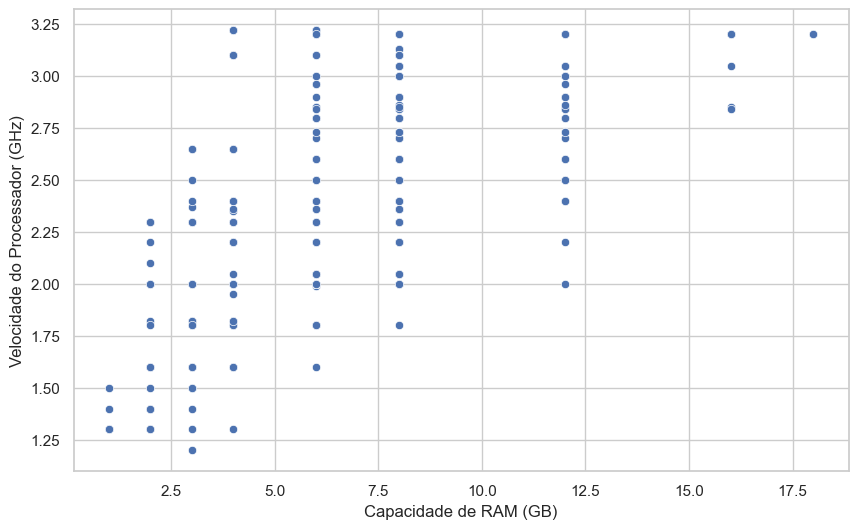

0.6272344553969902

In [3]:
# Vamos decidir o que fazer sobre os valores faltantes, começando pela velocidade de processamento.
# Vamos analisar a relação entre RAM e processamento.

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

correlation = df["processor_speed"].corr(df["ram_capacity"])

# Criando o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(x = "ram_capacity", y="processor_speed", data=df)
plt.xlabel("Capacidade de RAM (GB)")
plt.ylabel("Velocidade do Processador (GHz)")
plt.show()

correlation

Com uma relação de 0.6272, podemos concluir que a relação entre qualidade do processador e capacidade de RAM é moderadamente forte. Então, para os casos com velocidade de processamento ausente, vamos pegar a mediana dos casos que têm a mesma capacidade de RAM.

Para a bateria, vamos pegar a mediana dos valores também, já que não são muitos casos que estão com ela ausente.

Já para o rating, vamos ignorar ele para os casos onde ele não existe.

In [4]:


# Etapa 1: Pegando a mediana de processamento por grupo de RAM
df['processor_speed'] = df['processor_speed'].fillna(df.groupby('ram_capacity')['processor_speed'].transform('median'))

# Etapa 2:
df["battery_capacity"] = df["battery_capacity"].fillna(df["battery_capacity"].median())

# Etapa 3: Substituímos os ratings ausentes pela média
df = df.dropna(subset=["rating"])


# Verificando novamente os valores faltantes
missing_value_updated = df[["processor_speed", "rating", "battery_capacity"]].isnull().sum()
missing_value_updated

processor_speed     0
rating              0
battery_capacity    0
dtype: int64

In [5]:
from sklearn.preprocessing import MinMaxScaler
from math import log2
import numpy as np

pesos = {
    "rating" : 0.15,
    "ram" : 0.20,
    "processor_speed" : 0.15,
    "screen_size" : 0.15,
    "camera" : 0.20,
    "battery" : 0.15
}

# 2. Normalizar o Rating (substituir valores ausentes pela média e normalizar)
df.loc[:, "rating"] = df["rating"].fillna(df["rating"].mean())
df.loc[:, "rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))

# 3. Ajustar a RAM (cresce até 8GB e depois se estabiliza)
df.loc[:, "ram_adjusted"] = df["ram_capacity"].apply(lambda x: x if x <= 8 else 8 + (x - 8) * 0.1)

# 4. Ajustar o Tamanho da Tela (cresce até um ponto ideal e depois se estabiliza)
tamanho_tela_ideal = 6.0
df.loc[:, "screen_size_adjusted"] = df["screen_size"].apply(lambda x: x if x <= tamanho_tela_ideal else tamanho_tela_ideal)

# 5. Normalizar Velocidade do Processador, Qualidade da Câmera e Capacidade da Bateria
df.loc[:, "processor_speed"] = MinMaxScaler().fit_transform(df["processor_speed"].values.reshape(-1, 1))
df.loc[:, "primary_camera_rear"] = MinMaxScaler().fit_transform(df["primary_camera_rear"].values.reshape(-1, 1))
df.loc[:, "battery_capacity"] = MinMaxScaler().fit_transform(df["battery_capacity"].values.reshape(-1, 1))

# Aplicando a transformação logarítmica ao preço
df.loc[:, "price_log"] = np.sqrt(df["price"] + 1)

# 6. Calcular o Índice de Custo-Benefício
df.loc[:, "custo_beneficio"] = (pesos["rating"] * df["rating"] +
                         pesos["ram"] * df["ram_adjusted"] +
                         pesos["processor_speed"] * df["processor_speed"] +
                         pesos["screen_size"] * df["screen_size_adjusted"] +
                         pesos["camera"] * df["primary_camera_rear"] +
                         pesos["battery"] * df["battery_capacity"]) / df["price_log"]

# 7. Categorizar o Índice de Custo-Benefício
df.loc[:, "custo_beneficio_categoria"] = pd.qcut(df["custo_beneficio"], q=[0, .25, .75, 1], labels=["baixo", "medio", "alto"])

df[["custo_beneficio", "custo_beneficio_categoria"]].head()

,custo_beneficio,custo_beneficio_categoria
0,0.012561,baixo
1,0.016698,medio
2,0.015032,medio
3,0.019158,alto
4,0.015452,medio


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

x = df.iloc[:, 0:7].values
y = df.iloc[: 7].values